03/09/2021 First example on Approximate Bayesian Computation. 
Please read Beaumont (2010), a very good introduction to ABC. 

We will first simulate our "real" data with known parameters, and then use ABC to re-estimate them. We will of course need some summary statistics, and they will be LD-based. 

In [5]:
# LOAD SOME PACKAGES
require(compiler)
enableJIT(3)
require(doParallel)

[1] 3

In [10]:
# DEFINE SOME FUNCTIONS
fsum<-function(x) {.Primitive('sum')(x)}
f1<-function(x, i) {x[[i]]}
f2<-function(x, i)
{
    temp<-lapply(x, f1, i=i)
    temp<-matrix(unlist(temp), byrow=T, nr=length(x))
}
gc2<-function() {invisible(gc())}

In [11]:
# REUSE SOME SCRIPTS I WROTE BEFORE
source('aestivation1.txt')
ls()

[1] "aestivation1.txt IS LOADED!"


[1] "f1"              "f2"              "fsum"            "gc2"            
 [5] "j"               "loci"            "real_m"          "real_N1"        
 [9] "real_N2"         "real_r1r2"       "real_r21"        "real_r22"       
[13] "sim_aestivation" "sim_migration"   "sim_seasonal"    "t1"             
[17] "t2"

Now we're going to generate the "real" data. Let's assume we have 100 pairs of loci, all with $c=0.5$. We also assume that the true parameters are $N_1=N_2=500$, and $m=0.2$. From previous exercise we think simulating 20 generations forward in time will be enough for migration and recombination to settle. 

Now let's consider our summary statistics. I'm using $r_{1}^2$ and $r_{2}^2$, the LD measure on the two populations. I'm also including $r_1*r_2$, the Sved's between-population LD measure (You may use something else here). 

Here I assume symmetric migration with only one migration parameter. In theory I need the 4th summary statistics for unequal m.  

In [28]:
# GENERATE "REAL" DATA. N1=N2=500, m1=m2=0.2, c=0.5
real_N1<-500
real_N2<-500
real_m<-0.2

loci<-100
temp_r21<-rep(NA, loci)
temp_r22<-rep(NA, loci)
temp_r1r2<-rep(NA, loci)

t1<-proc.time()
dyn.load('cpp/aestivation1.dll')
for (j in 1:loci)
{
    temp<-sim_migration(N1=rep(real_N1, 20), N2=rep(real_N2, 20), 
                        m1=rep(real_m, 20), m2=rep(real_m, 20), c=0.5)
    temp_r21[j]<-temp$pop1_r2[21]
    temp_r22[j]<-temp$pop2_r2[21]
    temp_r1r2[j]<-temp$pop12_rr[21]
}
t2<-proc.time()
dyn.load('cpp/aestivation1.dll')
# THE "REAL" SUMMARY STATISTICS ARE THE AVERAGE FROM 10 LOCI
real_r21<-mean(temp_r21)
real_r22<-mean(temp_r22)
real_r1r2<-mean(temp_r1r2)
rm(temp); rm(temp_r21); rm(temp_r22); rm(temp_r1r2); gc2();

In [29]:
# THE "REAL" SUMMARY STATISTICS VALUES
c(real_r21, real_r22, real_r1r2)
# HOW LONG DOES IT TAKE TO SIM ONE SET?
t2-t1

[1] 0.0017574812 0.0015247271 0.0004840448

   user  system elapsed 
   0.33    0.00    0.33 

Now we got our "real" summary statistics. The next steps are to sample parameters from prior distributions, simulate loci under these parameter values, and calculate summary statistics. 

We will then match these simulated summary statistics against our "real" one (more about this later). 

For my prior, I sample $N_1$ and $N_2$ from uniform(50, 2000), and $m$ from uniform(0, 0.5), indepenently. Then I will use each set of piror parameters to simulate "fake" data and summary statistics (while keeping other factors the same). I aim to draw 10,000 sets of parameters and simulated summary statistics before keeping/rejecting them. You can of course make such decision on the fly (save memory space). 

In [30]:
k<-10000
prior_N1<-round(runif(k, 50, 2000))
prior_N2<-round(runif(k, 50, 2000))
prior_m<-runif(k, 0 ,0.5)
loci<-100

# ABC, SPREAD ACROSS MANY CPU CORES. IT MAY TAKE A WHILE
cl<-makeCluster(44)
registerDoParallel(cl)
result<-foreach(i=1:k, .combine='rbind') %dopar%
{
    if (!is.loaded('allele_freq')) {dyn.load('cpp/aestivation1.dll')}
    # EACH SIM WILL HAVE 100 LOCI, AND WE TAKE THE AVERAGE
    temp_r21<-rep(NA, loci)
    temp_r22<-rep(NA, loci)
    temp_r1r2<-rep(NA, loci)
    for (j in 1:loci)
        {
        temp<-sim_migration(N1=rep(prior_N1[i], 20), N2=rep(prior_N2[i], 20), 
                            m1=rep(prior_m[i], 20), m2=rep(prior_m[i], 20), c=0.5)
        temp_r21[j]<-temp$pop1_r2[21]
        temp_r22[j]<-temp$pop2_r2[21]
        temp_r1r2[j]<-temp$pop12_rr[21]
        }
    return(c(mean(temp_r21), mean(temp_r22), mean(temp_r1r2)))
}
stopCluster(cl)
dim(result)

[1] 10000     3

In [31]:
# SAVE ALL RESULTS JUST IN CASE WE LOST THEM
save(real_N1, real_N2, real_m, real_r21, real_r22, real_r1r2, 
     prior_N1, prior_N2, prior_m, result, file='ABC example.RData')
gc2()

In [32]:
# READ BACK RESULTS
load('ABC example.RData')

Now we have a bunch of "fake" or simulated summary statistics. we can plot them out and see how they look like, and how they react with prior parameter values. In our case, we knew that $r^2_1$ contains information about $N_1$, and so on. But in reality we may not exactly know the relationships among paramters and summary statistics. 

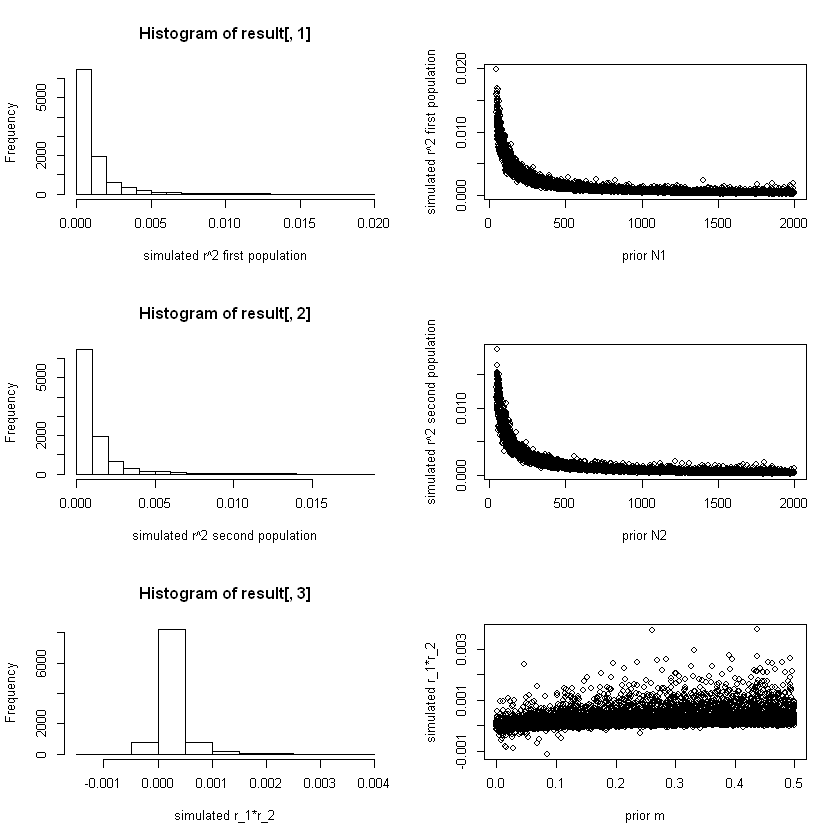

In [36]:
par(mfrow=c(3,2))
hist(result[,1], xlab='simulated r^2 first population')
plot(prior_N1, result[,1], xlab='prior N1', ylab='simulated r^2 first population')

hist(result[,2], xlab='simulated r^2 second population')
plot(prior_N2, result[,2], xlab='prior N2', ylab='simulated r^2 second population')
hist(result[,3], xlab='simulated r_1*r_2')
plot(prior_m, result[,3], xlab='prior m', ylab='simulated r_1*r_2')

The next step is to work out measure how close these simulations are to our "real" dataset. I do not have a concrete idea about the best distance measure, Beaumont might have better idea. 

In [49]:
# CALCULATE DISTANCE. I USE THE VARIANCE TO NORMALISE THE DISTANCE
variance<-apply(result, 2, var, na.rm=T)
distance<-sqrt((result[,1]-real_r21)^2/variance[1]+(result[,2]-real_r22)^2/variance[2]+(result[,3]-real_r1r2)^2/variance[3])

Now, instead of rejecting simulations with large distance, I decide to accept 500 (5%) sims with the smallest distance as my posterior candidates. There are of course better ways, but for demonstration it's good enough. 

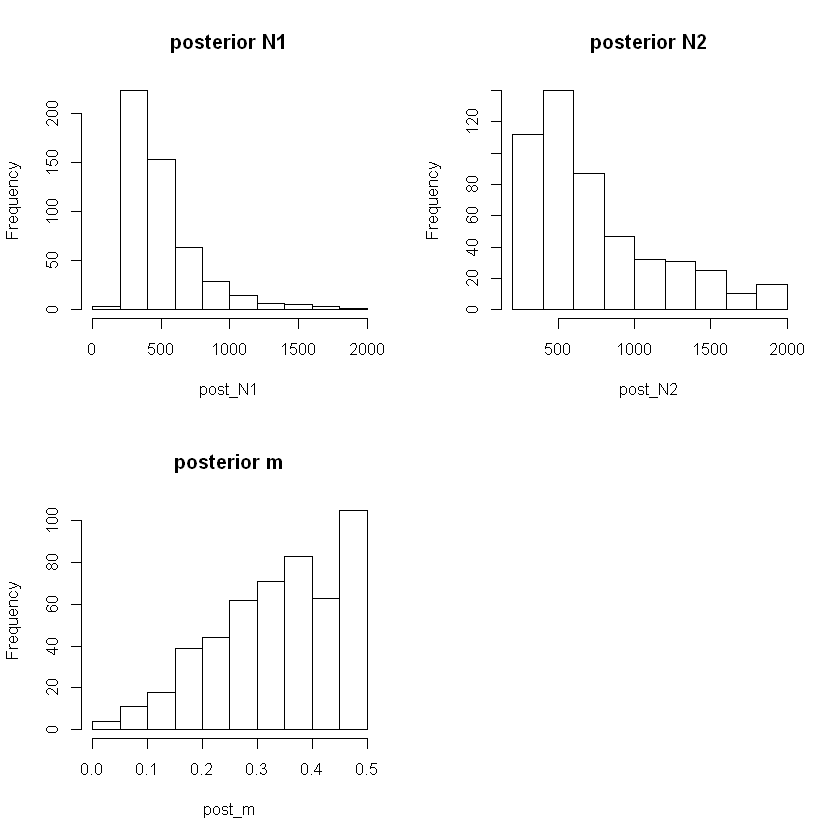

In [50]:
# LET'S SAY WE PICK THE 500 "CLOSEST" SIMULATIONS AS OUR POSTERIOR
post_N1<-prior_N1[order(distance)[1:500]]
post_N2<-prior_N2[order(distance)[1:500]]
post_m<-prior_m[order(distance)[1:500]]

par(mfrow=c(2,2))
hist(post_N1, main='posterior N1')
hist(post_N2, main='posterior N2')
hist(post_m, main='posterior m')

In [51]:
# POSTERIOR MEAN?
mean(post_N1)
mean(post_N2)
mean(post_m)

[1] 504.828

[1] 736.914

[1] 0.3373297

The estimation of m isn't great. Perhaps we don't have enough loci? Or use smaller c?